In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison

In [2]:
# Where to put simulated data
tmp_dir='/scratch/bonaiuto/simulated_data/model_comp_fe'

# Subject information for data to base simulations on
subj_id='sub-104'
ses_id='ses-01'
# Fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data','spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')
# Mesh to use for forward model
multilayer_mesh_fname = os.path.join('../test_output', subj_id, 'multilayer.11.ds.link_vector.gii')

# Get name of each mesh that makes up the layers of the multilayer mesh
n_layers=11
layers = np.linspace(1, 0, n_layers)
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join('../test_output', subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join('../test_output', subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join('../test_output', subj_id, 'white.ds.link_vector.gii'))
    
# Load multilayer mesh and compute the number of vertices per layer
mesh=nib.load(multilayer_mesh_fname)
verts_per_surf=int(mesh.darrays[0].data.shape[0]/n_layers)

# Data file to base simulations on
data_file=os.path.join('../test_data', 'processed', subj_id, ses_id, 'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(os.path.join(data_path, f'{data_base}.mat'), os.path.join(tmp_dir, f'{data_base}.mat'))
shutil.copy(os.path.join(data_path, f'{data_base}.dat'), os.path.join(tmp_dir, f'{data_base}.dat'))

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

In [3]:
# Invert the subject's data. This step only has to be done once - this is just to compute the forward model
# that will be used in the simulations

# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size=5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname)

# Run inversion
[_,_]=invert_ebb(multilayer_mesh_fname, base_fname, n_layers, patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


Text(0, 0.5, 'Amplitude (nAm)')

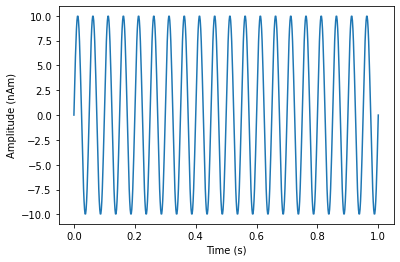

In [4]:
# Vertex to simulate activity at
sim_vertex=24588
# Frequency of simulated sinusoid (Hz)
freq=20
# Strength of simulated activity (nAm)
dipole_moment=10
# Size of simulated patch of activity (mm)
sim_patch_size=5
# SNR of simulated data (dB)
SNR=-5

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,1,601)
sim_signal=np.sin(time*freq*2*np.pi).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [5]:
# Simulate at a vertex on the pial surface
pial_vertex=sim_vertex
prefix=f'sim_{sim_vertex}_pial.'

# Generate simulated data
pial_sim_fname=run_current_density_simulation(base_fname, prefix, pial_vertex, sim_signal, dipole_moment, 
                                              sim_patch_size, SNR)    

# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_]=model_comparison(nas, lpa, rpa, mri_fname, [layer_fnames[0], layer_fnames[-1]], pial_sim_fname, 
                       patch_size=patch_size, n_temp_modes=n_temp_modes)

# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be positive (more model evidence for the pial layer model)
F[0]-F[1]

Smoothing ../test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


15344.07307793008

In [6]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex=(n_layers-1)*verts_per_surf+sim_vertex
prefix=f'sim_{sim_vertex}_white.'

# Generate simulated data
white_sim_fname=run_current_density_simulation(base_fname, prefix, white_vertex, sim_signal, dipole_moment, 
                                               sim_patch_size, SNR) 
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_]=model_comparison(nas, lpa, rpa, mri_fname, [layer_fnames[0], layer_fnames[-1]], white_sim_fname, 
                       patch_size=patch_size, n_temp_modes=n_temp_modes)
    
# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be negative (more model evidence for the white matter layer model)
F[0]-F[1]

Smoothing ../test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


-5824.759629056498

In [7]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
all_layerF=[]

for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex=l*verts_per_surf+sim_vertex
    prefix=f'sim_{sim_vertex}_{l}.'

    l_sim_fname=run_current_density_simulation(base_fname, prefix, l_vertex, sim_signal, dipole_moment, 
                                               sim_patch_size, SNR, viz=False) 

    [layerF,_]=model_comparison(nas, lpa, rpa, mri_fname, layer_fnames, l_sim_fname, 
                                patch_size=patch_size, n_temp_modes=n_temp_modes, 
                                viz=False)
    all_layerF.append(layerF)
all_layerF=np.array(all_layerF)

Simulating in layer 0
Smoothing ../test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ../test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ../test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ../test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ../test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ../test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ../test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ../test_output/sub-104/0.200.ds.link_vector.gii
FWHM of 5.00 is approx 3.48 times vertex spacing
Smoothing ../tes

Smoothing ../test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing
Simulating in layer 7
Smoothing ../test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ../test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ../test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ../test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ../test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ../test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ../test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ../tes

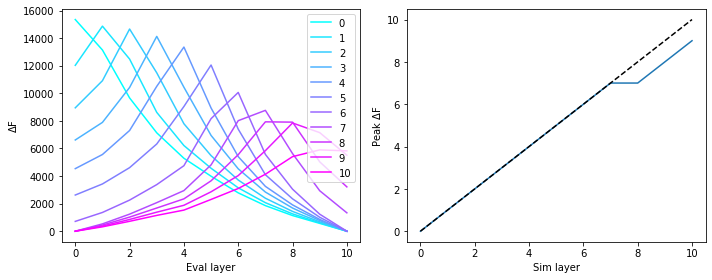

In [8]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF=all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerF=all_layerF[l,:]
    pk=np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [9]:
# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)